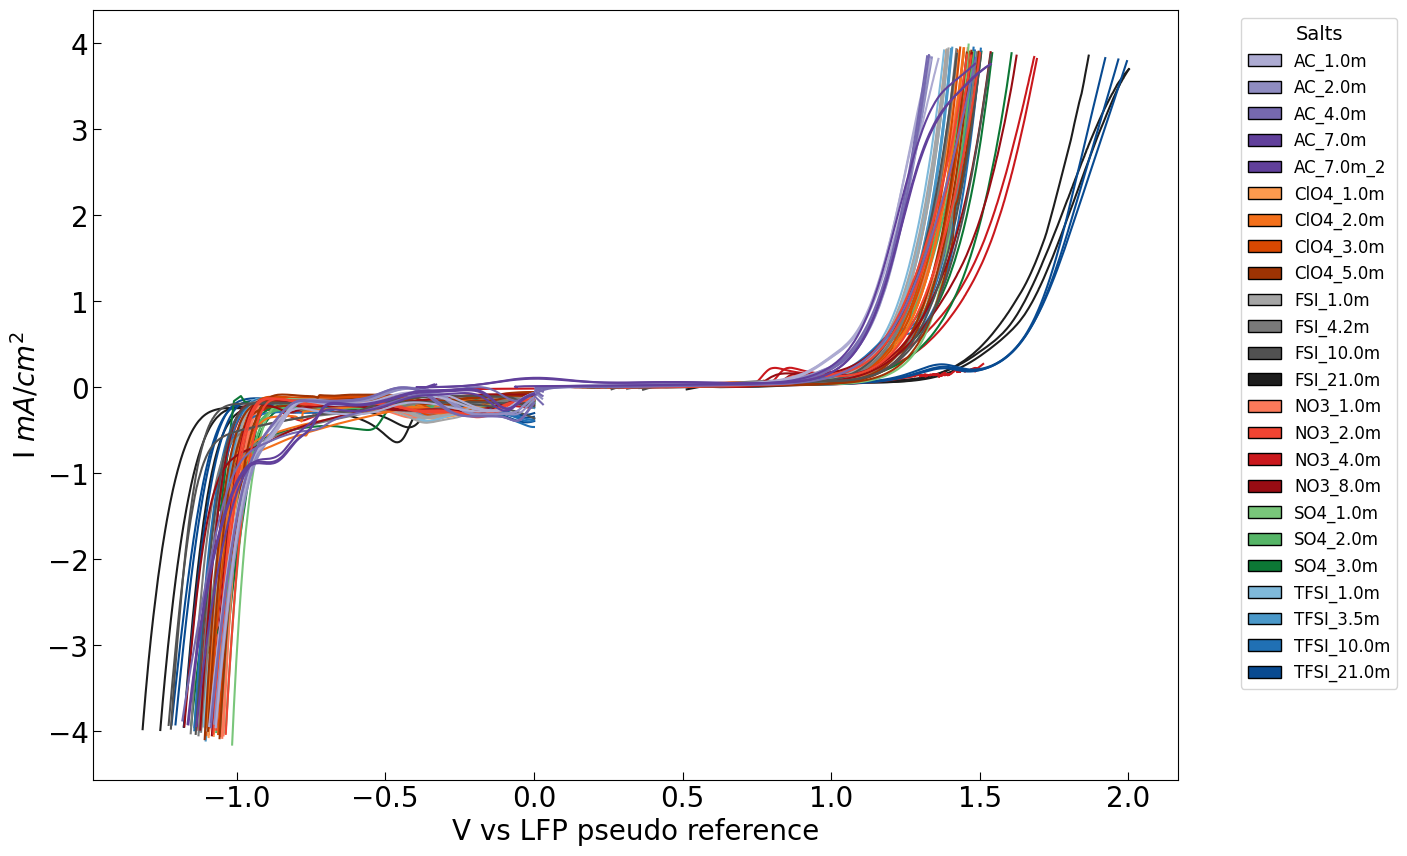

C:\Users\llf1362\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:286: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\llf1362\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:287: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


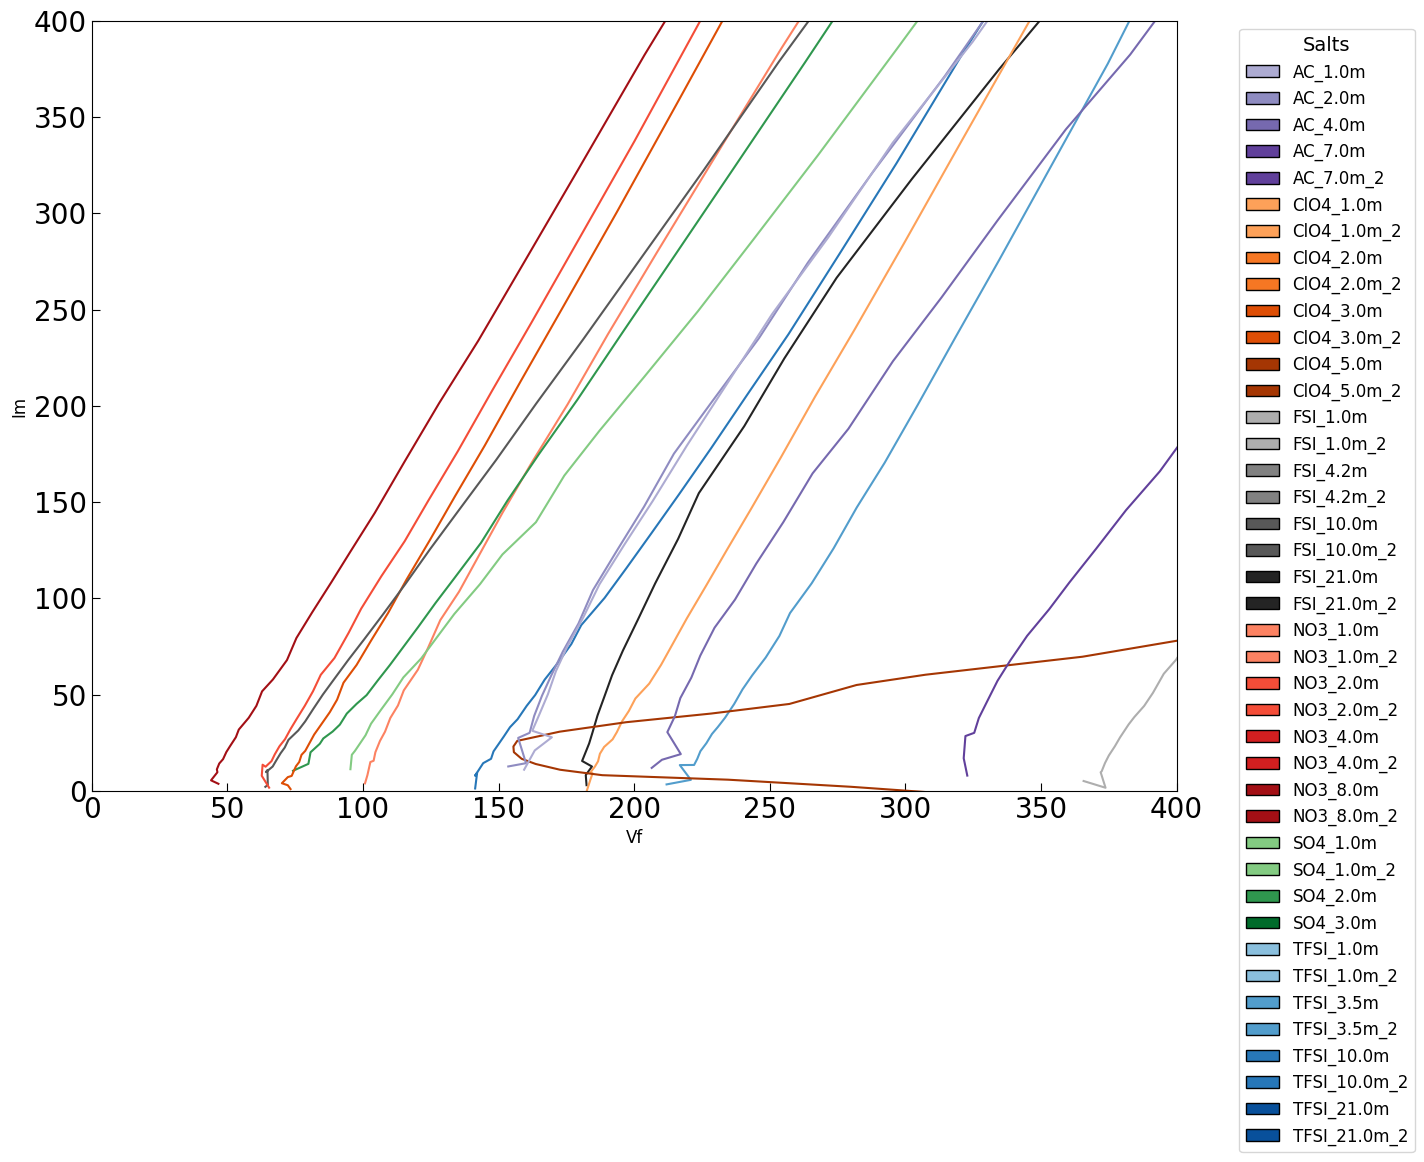

In [76]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.cm as cm

from matplotlib.patches import Patch
from pathlib import Path

# enter folder containing CSVs to plot

# Group files by similar names (ignoring the last digit)
def get_grouped_files(files):
    grouped = {}
    for filename in files:
        # Assuming the last digit is at the end before the file extension
        base_name = filename.rsplit('_', 1)[0]
        if base_name not in grouped:
            grouped[base_name] = []
        grouped[base_name].append(filename)
    return grouped

def find_peaks_and_zero_crossings(data):
    # Find the index of the first occurrence of zero in 'Vf'
    zero_index = np.argmax(data['Vf'] >= 0)
    
    # Find the positive peak (maximum after the first zero crossing)
    positive_peak_index = np.argmax(data['Im'][zero_index:]) + zero_index
    
    # Find where the voltage crosses 0 after the positive peak
    # We are looking for the first zero-crossing point after the positive peak
    zero_cross_index = np.argmax(np.diff(np.sign(data['Vf'][positive_peak_index:])) != 0) + positive_peak_index
    
    # Find the negative peak (minimum after the 0V crossing)
    negative_peak_index = np.argmin(data['Im'][zero_cross_index:]) + zero_cross_index
    
    return positive_peak_index, zero_cross_index, negative_peak_index

def parse_files(file_list, type="cv"):
    """
    Currently only works for single salts! Assume three tests per salt.

    type is either cv or geis
    """
    salts_to_conc_list = {}
    salts = set()

    # tuple of salts and concentrations
    salt_and_conc = set()

    for file in file_list:
        stem = Path(file).stem
        stem_split = stem.split("_")

        # more than one salt
        if len(stem_split) != 3:
            continue

        salt, conc, test_type = stem_split

        # first part should be salt name
        salts.add(salt)

        # get conc
        conc = conc[:-1]
        dec_conc = float(conc.replace("p", "."))

        # keep track
        if salt in salts_to_conc_list:
            salts_to_conc_list[salt].append(dec_conc)
        else:
            salts_to_conc_list[salt] = [dec_conc]

        # from test_type, determine the test number for this test
        if type == "cv":
            suffix_length = 3
        else:
            suffix_length = 5

        test_num = test_type[:-suffix_length]

        if test_num == "":
            test_num = 1
        else:
            test_num = int(test_num)

        salt_and_conc.add((salt, conc, test_num))

    return salts, salt_and_conc, salts_to_conc_list

class CVPlotter():
    def __init__(self, folder_path):
        self.path = Path(folder_path)
        self.csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    def same_mat_diff_conc(self):
        cmap = cm.Blues
        plt.figure(figsize=(14, 10))
        for i, file in enumerate(self.csv_files):
            path = Path(file)
            df = pd.read_csv(path, index_col='# Point')
            positive_peak_index, zero_cross_index, negative_peak_index = find_peaks_and_zero_crossings(df)
            x = df["Vf"]
            y = df['Im']
            color = cmap(i / (len(self.csv_files) - 1))
            # Plot from 0 to positive peak
            plt.plot(x[:positive_peak_index+1],y[:positive_peak_index+1]*1000/0.020, color=color)
            
            # Plot from 0V crossing to negative peak
            plt.plot(x[zero_cross_index:negative_peak_index+1],y[zero_cross_index:negative_peak_index+1]*1000/0.020, color=color)

        plt.xlabel("Vf")
        plt.ylabel("Im")
        plt.show()
        
    def same_conc_diff_mat(self):
        plt.figure(figsize=(14, 10))
        for file in self.csv_files:
            path = Path(file)
            df = pd.read_csv(path, index_col='# Point')
            x = df["Vf"].to_numpy()
            y = df["Im"].to_numpy()

    def diff_mat_diff_conc(self):
        """
        Plot folder of data. 
        """

        sequential_cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

        salts, salt_and_conc, salt_to_conc_list = parse_files(self.csv_files, type="cv")

        # assign each salt a colormap
        salt_to_cmap = {}

        i = 0
        for salt in salts:
            salt_to_cmap[salt] = plt.get_cmap(sequential_cmaps[i])
            i += 1

        plt.figure(figsize=(14, 10))
        legend_elements = []
        for tup in salt_and_conc:
            salt, conc, test_num = tup

            # rebuild file name
            if test_num == 1:
                prefix  = ""
            else:
                prefix = "_" + str(test_num)

            # we have three sets of data per run, one colour per run
            cmap = salt_to_cmap[salt]
            dec_conc = float(conc.replace("p", "."))
            conc_list = sorted(salt_to_conc_list[salt])
            ratio = (conc_list.index(dec_conc) + 1) / len(conc_list)

            cmap_intensity = 0.4 + ratio * 0.6
            plot_group_name = f"{salt}_{str(dec_conc)}m{prefix}"
            legend_elements.append(
                Patch(facecolor=cmap(cmap_intensity), edgecolor='black', label=plot_group_name)
            )

            # get corresponding cmap

            for i in range(3):

                file_name = f"{salt}_{conc}m_{prefix}cv{str(i)}.csv"
                path = self.path / Path(file_name)

                try:
                    df = pd.read_csv(path, index_col='# Point')
                except:
                    continue

                positive_peak_index, zero_cross_index, negative_peak_index = find_peaks_and_zero_crossings(df)
                x = df["Vf"]
                y = df['Im']

                # Plot from 0 to positive peak
                plt.plot(x[:positive_peak_index+1],
                        y[:positive_peak_index+1]*1000/0.020,
                        color = cmap(cmap_intensity),
                        )
                
                # Plot from 0V crossing to negative peak
                plt.plot(x[zero_cross_index:negative_peak_index+1],
                        y[zero_cross_index:negative_peak_index+1]*1000/0.020, 
                        color = cmap(cmap_intensity)
                        )

        # Custom sorting function
        def sort_key(s):
            s = s[0]
            # Split the string into prefix and numeric part
            prefix, num = s.split('_', 1)
            # Remove the 'm' and convert the numeric part to a float
            num = float(num.replace('m', ''))
            return (prefix, num)

        label_element_pairs = [(patch.get_label(), patch) for patch in legend_elements]
        label_element_pairs.sort(key=sort_key)  # Sort by label
        sorted_legend_elements = [patch for _, patch in label_element_pairs]

        # Add legend to the plot
        plt.legend(handles=sorted_legend_elements,  bbox_to_anchor=(1.05, 1), title="Salts", fontsize=12, title_fontsize=14, loc='upper left')
        plt.xlabel("V vs LFP pseudo reference", fontsize=20)
        plt.ylabel("I "  r"$mA/cm^2$", fontsize=20)
        plt.tick_params(axis='both', direction='in', length=6)
        plt.grid(False)
        plt.show()

    def set_path(self, new_path):
        # set new folder path to read CSVs
        self.path = Path(new_path)
        self.csv_files = [f for f in os.listdir(new_path) if f.endswith(".csv")]


class GEISPlotter():
    def __init__(self, folder_path):
        self.path = Path(folder_path)
        self.csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    def same_mat_diff_conc(self, showavg = False):
        # set showavg = True to show average zreals on legend
        for file in self.csv_files:
            path = Path(file)
            df = pd.read_csv(path, index_col='# point')
            x = df['zreal'].to_numpy()
            y = df['reflected_zimag'].to_numpy()

    def same_conc_diff_mat(self):
        for file in self.csv_files:
            path = Path(file)
            df = pd.read_csv(path, index_col='# point')
            x = df['zreal'].to_numpy()
            y = df['reflected_zimag'].to_numpy()

    def diff_mat_diff_conc(self):
        """
        Plot folder of data. 
        """

        sequential_cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

        salts, salt_and_conc, salt_to_conc_list = parse_files(self.csv_files, type="geis")

        # assign each salt a colormap
        salt_to_cmap = {}

        i = 0
        for salt in salts:
            salt_to_cmap[salt] = plt.get_cmap(sequential_cmaps[i])
            i += 1


        plt.figure(figsize=(14, 10))
        legend_elements = []
        for tup in salt_and_conc:
            salt, conc, test_num = tup

            # rebuild file name
            if test_num == 1:
                prefix  = ""
            else:
                prefix = "_" + str(test_num)

            # we have three sets of data per run, one colour per run
            cmap = salt_to_cmap[salt]
            dec_conc = float(conc.replace("p", "."))
            conc_list = sorted(salt_to_conc_list[salt])
            ratio = (conc_list.index(dec_conc) + 1) / len(conc_list)

            cmap_intensity = 0.4 + ratio * 0.6
            plot_group_name = f"{salt}_{str(dec_conc)}m{prefix}"
            legend_elements.append(
                Patch(facecolor=cmap(cmap_intensity), edgecolor='black', label=plot_group_name)
            )

            # get corresponding cmap
            zreal_totals = pd.Series()
            zimag_totals = pd.Series()
            n = 0

            for i in range(3):

                file_name = f"{salt}_{conc}m_{prefix}geis{str(i)}.csv"
                path = self.path / Path(file_name)

                try:
                    df = pd.read_csv(path, index_col='# point')
                except:
                    continue

                if zreal_totals.empty:
                    zreal_totals = df["zreal"]
                    zimag_totals = df['reflected_zimag']
                else:
                    zreal_totals += df["zreal"]
                    zimag_totals += df['reflected_zimag']

                n += 1

            zreal_avg = zreal_totals / n
            zimag_avg = zimag_totals / n

            plt.plot(
                zreal_avg, zimag_avg, 
                label=None,  # No individual label for each file
                color=cmap(cmap_intensity)
            )

        # Custom sorting function
        def sort_key(s):
            # Split the string into prefix and numeric part
            s = s[0]
            prefix, num = s.split('_', 1)
            # Remove the 'm' and convert the numeric part to a float
            num = float(num.replace('m', ''))
            return (prefix, num)

        label_element_pairs = [(patch.get_label(), patch) for patch in legend_elements]
        label_element_pairs.sort(key=sort_key)  # Sort by label
        sorted_legend_elements = [patch for _, patch in label_element_pairs]

        # Add legend to the plot
        plt.ylim((0, 400))
        plt.xlim((0, 400))
        plt.legend(handles=sorted_legend_elements, bbox_to_anchor=(1.05, 1), title="Salts", fontsize=12, title_fontsize=14, loc='upper left')
        plt.xlabel("Vf", fontsize=12)
        plt.ylabel("Im", fontsize=12)
        plt.tick_params(axis='both', direction='in', length=6)
        plt.grid(False)
        plt.show()

    def set_path(self, new_path):
        # set new folder path to read CSVs
        self.path = Path(new_path)
        self.csv_files = [f for f in os.listdir(new_path) if f.endswith(".csv")]

cvplotter = CVPlotter(Path(r"C:\Users\llf1362\Desktop\SingleSaltData\cv"))
cvplotter.diff_mat_diff_conc()
eisplotter = GEISPlotter(Path(r"C:\Users\llf1362\Desktop\SingleSaltData\eis"))
eisplotter.diff_mat_diff_conc()